In [1]:
# imports required to run the code.
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

c:\Users\Pedro Antônio Silva\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# preparing dataset.

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df = df.fillna(0)

# ---------------------------------------- #

df = df.replace(to_replace="Male",value="0")
df = df.replace(to_replace="Female",value="1")
df = df.replace(to_replace="Other",value="2")

df = df.replace(to_replace="No",value="0")
df = df.replace(to_replace="Yes",value="1")

df = df.replace(to_replace="Never_worked",value="0")
df = df.replace(to_replace="Private",value="1")
df = df.replace(to_replace="Self-employed",value="2")
df = df.replace(to_replace="Govt_job",value="3")
df = df.replace(to_replace="children",value="4")

df = df.replace(to_replace="Rural",value="0")
df = df.replace(to_replace="Urban",value="1")

df = df.replace(to_replace="never smoked",value="0")
df = df.replace(to_replace="formerly smoked",value="1")
df = df.replace(to_replace="smokes",value="2")
df = df.replace(to_replace="Unknown",value="3")

# ---------------------------------------- #

In [5]:
x = df[0:len(df)/2]
y = df[len(df)/2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

TypeError: cannot do slice indexing on RangeIndex with these indexers [2555.0] of type float

In [3]:
# ---------------------------------------- #

df_rotulo = df['id']
df_features = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]

tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(df_features, df_rotulo)

# ---------------------------------------- #

DecisionTreeClassifier(criterion='entropy')

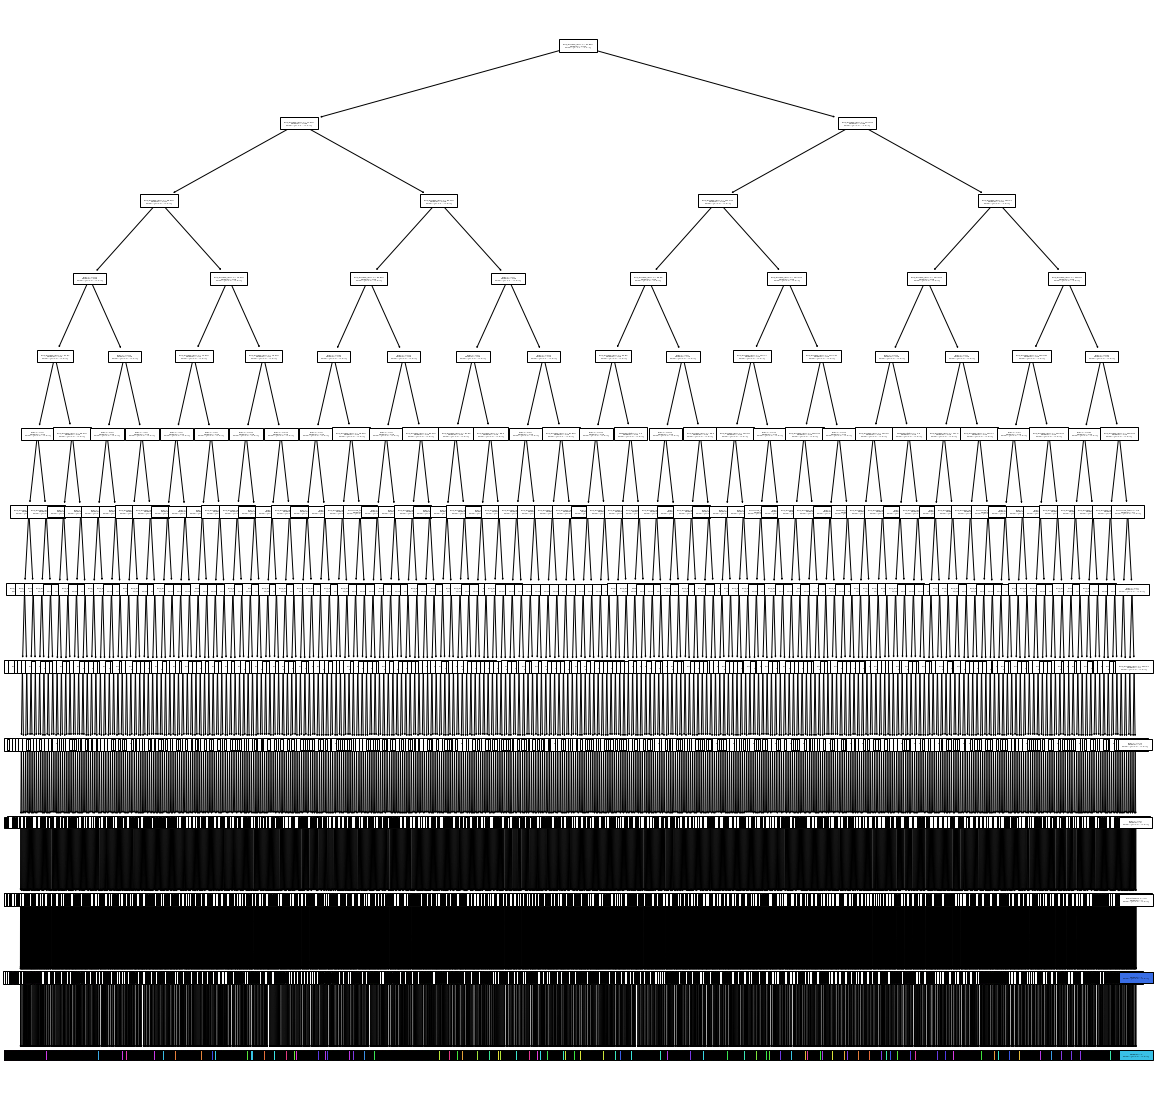

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=df_features.columns, fontsize=2, 
              node_ids=False, impurity=False, filled=True)